In [1]:
import tensorflow.compat.v1 as tf
import torch
from STGCN import *
import scipy.sparse as sp

/usr/local/lib/python3.8/dist-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
dataset_encode=torch.load('/root/data1/d_0.4_EMD/M_encode_output_01traj120050200ts_vis.pt')

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
n_frame=31
n_his=30
n=dataset_encode[0].x.shape[0]
C0=dataset_encode[0].x.shape[1]
edge_index=dataset_encode[0].edge_index
data=seq_gen(dataset_encode,  n_frame)#(190,11,n,C)
n_train=150
n_val=20
Ks=3
Kt=5
batch_size=10
epoch=300
opt='RMSProp'
lr=1e-3
save_=5
blocks = [[C0, 32, 64], [64, 32, 128]]

inputs,x_stats=data_gen(data, n_train, n_val)

In [4]:
print(inputs.get_data('train').shape)
print(inputs.get_data('val').shape)

torch.Size([150, 31, 3900, 26])
torch.Size([20, 31, 3900, 26])


In [5]:
W = sp.coo_matrix((torch.ones(edge_index.shape[1]).to('cpu'), (edge_index[0, :].to('cpu'), edge_index[1, :].to('cpu'))), 
                                    shape=(n, n), dtype=np.float32)
W = W + W.T.multiply(W.T > W) - W.multiply(W.T > W)
print(W.shape)

(3900, 3900)


In [6]:
W_dense = torch.tensor(W.toarray(), dtype=torch.float32)
L = scaled_laplacian(W_dense)
print(L.shape)

tensor(2.0000)
torch.Size([3900, 3900])


In [7]:
Lk = cheb_poly_approx(L, Ks, n)

In [8]:
print(Lk.shape)
tf.add_to_collection(name='graph_kernel', value=tf.cast(tf.constant(Lk), tf.float32))

(3900, 11700)


In [9]:
model_train(inputs, n, n_his, Ks, Kt,batch_size, epoch,opt,blocks, C0,lr,save_,x_stats)


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


2024-11-19 10:50:53.030838: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-11-19 10:50:53.491273: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 20516 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4090, pci bus id: 0000:9e:00.0, compute capability: 8.9
2024-11-19 10:50:57.399587: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8202
2024-11-19 10:50:58.345230: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-11-19 10:50:58.348720: W tensorflow/stream_executor/gpu/asm_compiler.cc:230] Falling back to the CUDA driver for PTX compilation; ptxas

Epoch  0: MSE  8.236%; MAE  0.210; RMSE  0.287.
Epoch  5: MSE  1.112%; MAE  0.075; RMSE  0.105.
Epoch 10: MSE  0.530%; MAE  0.049; RMSE  0.073.
Epoch 15: MSE  0.350%; MAE  0.038; RMSE  0.059.
Epoch 20: MSE  0.292%; MAE  0.034; RMSE  0.054.
Epoch 25: MSE  0.267%; MAE  0.033; RMSE  0.052.
Epoch 30: MSE  0.255%; MAE  0.032; RMSE  0.051.
Epoch 35: MSE  0.250%; MAE  0.032; RMSE  0.050.
Epoch 40: MSE  0.247%; MAE  0.032; RMSE  0.050.
Epoch 45: MSE  0.246%; MAE  0.031; RMSE  0.050.
Epoch 50: MSE  0.246%; MAE  0.031; RMSE  0.050.
Epoch 55: MSE  0.245%; MAE  0.031; RMSE  0.050.
Epoch 60: MSE  0.245%; MAE  0.031; RMSE  0.050.
Epoch 65: MSE  0.245%; MAE  0.031; RMSE  0.050.
Epoch 70: MSE  0.245%; MAE  0.031; RMSE  0.050.
Epoch 75: MSE  0.245%; MAE  0.031; RMSE  0.049.
Epoch 80: MSE  0.245%; MAE  0.031; RMSE  0.049.
Epoch 85: MSE  0.245%; MAE  0.031; RMSE  0.049.
Epoch 90: MSE  0.245%; MAE  0.031; RMSE  0.049.
Epoch 95: MSE  0.245%; MAE  0.031; RMSE  0.049.
Epoch 100: MSE  0.245%; MAE  0.031; RMSE

In [10]:
data_test=seq_gen(dataset_encode[0:n_frame],  n_frame)#[1,21,n,c0]
print(data_test.shape)
x_test = z_score(data_test, x_stats['mean'], x_stats['std'])
n_pred=170
y_test=model_test(x_test, x_stats,  n_his, n_pred, load_path='/root/data1/STGCN_result/saved_model/')#逆标准化
print(y_test.shape)#(180,n,c0)


torch.Size([1, 31, 3900, 26])
INFO:tensorflow:Restoring parameters from /root/data1/STGCN_result/saved_model/model.ckpt


2024-11-19 11:06:57.258790: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 20516 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4090, pci bus id: 0000:9e:00.0, compute capability: 8.9


>> Loading saved model from /root/data1/STGCN_result/saved_model/model.ckpt ...
(170, 3900, 26)
Testing model finished!
torch.Size([170, 3900, 26])


In [11]:
torch.save(y_test,'/root/data1/STGCN_result/ST_200_pred')

Mulit-attention

In [1]:
import copy
from  self_attention import *
from d_tap_processing import *
import numpy as np
import random

/usr/local/lib/python3.8/dist-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
a=torch.load('/root/data1/d_0.4_EMD/M_encode_output_01traj120050200ts_vis.pt')
edge_num=a[0].edge_attr.shape[0]
print(edge_num)    #14586
number_trajectories=1

14586


In [3]:
data_1=[]
data_label_1=[]

for i in range(number_trajectories):
    dataset_encode=torch.load('/root/data1/d_0.4_EMD/M_encode_output_01traj120050200ts_vis.pt')
    per_t=11
    for j in range(len(dataset_encode)-per_t+1):
        for k in range(per_t):
            if k <(per_t-1):
                E_data  = copy.deepcopy(dataset_encode[j+k])
                E_data=E_data.to('cpu')
                data_1.append(E_data)
            else:
                E_data  = copy.deepcopy(dataset_encode[j+k])
                E_data=E_data.to('cpu')
                data_label_1.append(E_data)
                       
print(len(data_1))      #140*10
print(len(data_label_1))   #140

data_=data_1
data_label=data_label_1



1900
190


In [4]:
device='cuda'
class objectview(object):
    def __init__(self, d):
        self.__dict__ = d   
for args in [
        {'model_type': 'Multi-attention',
         
         'batchsize': 5,       #是lable上的batchsize
         'hidden_dim': 26,     #这里的hidden_dim与encode_decode中的hidden_channels相同
         'epochs': 1000,#5000
         
         'train_size':150, #45
         'test_size': 40, #10         #按照lable的来
         'device':'cuda',
         'shuffle': False,
         'save_best_model': True,
         'checkpoint_dir': '/root/data1/d_0.4_EMD/Multi-attention_best_models/',
         'postprocess_dir': '/root/data1/d_0.4_EMD/Multi-attention_loss_plots/',
         'd_k': 28,#28
         'd_v': 28,
         'input_shape': 12,   #加上时间信息，所以比n_graph_encode的最后一个多两维
         'n_heads': 6,
         'n_layers': 5,
         'ff_dim': 64,
         'seq_len': 10,        #改per_t-1,二推一
         'per_t':11,
         
        'n_graph_encode':[500,150,80,10],
        'pool_num':[6500,4800,3900]},
]:
        args = objectview(args)
torch.manual_seed(5)  #Torch
random.seed(5)        #Python
np.random.seed(5)     #NumPy
torch.cuda.manual_seed_all(5)   #GPU

cuda


/usr/local/lib/python3.8/dist-packages/torch_geometric/deprecation.py:12: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)
Training:   0%|          | 1/1000 [00:09<2:40:28,  9.64s/Epochs]

train loss 0.932499 test loss 1.046553


Training:  10%|█         | 101/1000 [08:01<1:35:25,  6.37s/Epochs]

train loss 0.039708 test loss 0.037088


Training:  20%|██        | 201/1000 [15:55<1:22:48,  6.22s/Epochs]

train loss 0.030605 test loss 0.016696


Training:  30%|███       | 301/1000 [23:52<1:09:12,  5.94s/Epochs]

train loss 0.024875 test loss 0.012331


Training:  40%|████      | 401/1000 [32:03<59:45,  5.99s/Epochs]  

train loss 0.01866 test loss 0.010697


Training:  50%|█████     | 501/1000 [39:58<49:11,  5.91s/Epochs]

train loss 0.018283 test loss 0.010131


Training:  60%|██████    | 601/1000 [48:05<36:52,  5.54s/Epochs]

train loss 0.014953 test loss 0.008092


Training:  70%|███████   | 701/1000 [56:01<28:38,  5.75s/Epochs]

train loss 0.015161 test loss 0.009152


Training:  80%|████████  | 801/1000 [1:04:14<21:20,  6.43s/Epochs]

train loss 0.013976 test loss 0.008084


Training:  90%|█████████ | 901/1000 [1:12:17<09:38,  5.84s/Epochs]

train loss 0.014688 test loss 0.010236


Training: 100%|██████████| 1000/1000 [1:20:07<00:00,  4.81s/Epochs]

Min test set loss: 0.006552483420819044
Minimum loss: 0.01137032212379078


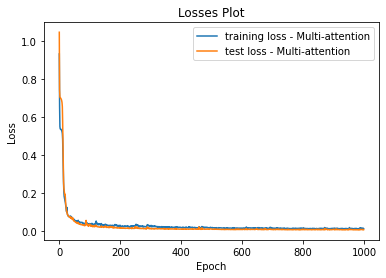

In [5]:
data_stats_list=torch.load('/root/data1/d_0.4_EMD/data_stats_list.pt')

device = 'cuda' if torch.cuda.is_available() else 'cpu'
args.device = device
print(device)

test_losses, losses, best_model,best_test_loss =Mulit_attention_train(data_,data_label, device,data_stats_list, args,edge_num)
print("Min test set loss: {0}".format(min(test_losses)))
print("Minimum loss: {0}".format(min(losses)))

save_plots(args, losses, test_losses)

In [6]:
per_t=1     #在编码和解码的时候每三个时刻个用的点是一样的
data_encode=torch.load('/root/data1/d_0.4_EMD/M_encode_output_01traj120050200ts_vis.pt')
print(len(data_encode))
data=copy.deepcopy(data_encode[0:10])
a=copy.deepcopy(data_encode[0])
print(a)

200
Data(x=[3900, 26], edge_index=[2, 14586], edge_attr=[14586, 26])


In [7]:
model_name='Multi-attention_model_nl'+'_bs'+str(args.batchsize) + \
               '_hd'+str(args.hidden_dim)+'_ep'+str(args.epochs)+'_wd' + \
               '_shuff_'+str(args.shuffle)+'_dk'+str(args.d_k)+'_heads'+str(args.n_heads)
args.batchsize=1
node_model = self_transformer(args,edge_num).to(device)
node_model.load_state_dict(torch.load('/root/data1/d_0.4_EMD/Multi-attention_best_models/'+model_name+'.pt'))

EDstats_list=torch.load('/root/data1/d_0.4_EMD/EDstats_list.pt')
data_stats_list=torch.load('/root/data1/d_0.4_EMD/data_stats_list.pt')
[EDmean_vec_x,EDstd_vec_x,EDmean_vec_edge,EDstd_vec_edge] = EDstats_list
(EDmean_vec_x,EDstd_vec_x,EDmean_vec_edge,EDstd_vec_edge)=(EDmean_vec_x.to(device),
        EDstd_vec_x.to(device),EDmean_vec_edge.to(device),EDstd_vec_edge.to(device))
[mean_vec_x,std_vec_x,mean_vec_edge,std_vec_edge] = data_stats_list
(mean_vec_x,std_vec_x,mean_vec_edge,std_vec_edge)=(mean_vec_x.to(device),std_vec_x.to(device),
                                                   mean_vec_edge.to(device),std_vec_edge.to(device))

In [8]:
def predict_sequences_multiple(model, data, a, predict_num,seq_len):

        print('[Model] Predicting Sequences Multiple...')
        a=a.to(device)
        code_index=a.edge_index
        for i in range(predict_num):
          list_p = data[:] if i == 0 else data[i:]
          data_loader=DataLoader(list_p, batch_size=seq_len, shuffle=False) 
          for i,batch in enumerate(data_loader):
              batch=batch.to(device)
              code_x,code_edge_attr = Mulit_attention_pred(batch,model,mean_vec_x,std_vec_x,mean_vec_edge,std_vec_edge)
          
          new_data=Data(x=code_x, edge_index=code_index, edge_attr=code_edge_attr)
          data.append(new_data)

        return data

In [9]:
predict_num=190
seq_len=10
data=predict_sequences_multiple(node_model, data, a, predict_num,seq_len)
print(len(data))  #60

[Model] Predicting Sequences Multiple...


/usr/local/lib/python3.8/dist-packages/torch_geometric/deprecation.py:12: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


200


In [10]:
torch.save(data,'/root/data1/STGCN_result/MultiAttention_200_pred')

In [11]:
from d_TAP_MP_Attention import *

In [12]:
in_channels_node = 2  #2
in_channels_edge = 3  #3
hidden_channels = 26#24    #22#12
out_channels = in_channels_node
batch_size =25       #改25
n_mlp_encode = 4
n_mlp_mp = 5#5
encoding_dim=32#32
ae_dim=[160,128,64,32]#[128,64,32,16,10][300,128,64,32]
n_mp_down = [2,2,1,1]
n_mp_up= [1,1,2,2]
pool_num =[6500,4800,3900]#[2000,1500,1200,1000][2000,1600,1400,1000]

act = F.elu
param_sharing = False
pathD='/root/data1/d_0.4_EMD/Decode_state_dict.pt'

In [13]:
i=0
dataset_dir = '/root/data1/d_0.4_EMD'
batches=torch.load(dataset_dir+'/'+str(i)+str(number_trajectories)+'traj'+'batches.pt')
xs=torch.load(dataset_dir+'/'+str(i)+str(number_trajectories)+'traj'+'xs.pt')
positions=torch.load( dataset_dir+'/'+str(i)+str(number_trajectories)+'traj'+'positions.pt')
edge_attrs=torch.load( dataset_dir+'/'+str(i)+str(number_trajectories)+'traj'+'edge_attrs.pt')
edge_indices=torch.load( dataset_dir+'/'+str(i)+str(number_trajectories)+'traj'+'edge_indices.pt')
edge_masks=torch.load(dataset_dir+'/'+str(i)+str(number_trajectories)+'traj'+'edge_masks.pt')


perm_list=torch.load(dataset_dir+'/perm_list_150.pt')




decode_model=GNN_Decode(
                hidden_channels,
                in_channels_node,
                in_channels_edge,
                
                out_channels,
                encoding_dim,
                n_mlp_mp,
                n_mlp_encode,

                ae_dim,
                n_mp_down,
                n_mp_up,
                pool_num,
                
                act,
                
                name='gnn_topk')
decode_model.load_state_dict(torch.load(pathD), strict=False)
decode_model.to(device)

pred_x=[]
with torch.no_grad():
        for i in range(len(data)):
              x=decode_model(data[i], batches , xs, positions, edge_attrs, edge_indices, edge_masks,perm_list[0])
              x=x*EDstd_vec_x+EDmean_vec_x
              pred_x.append(x)

              
print(len(pred_x))

200


In [14]:
def ROM_transform_vector(data, satart_number_ts,number_ts, originalFolder, destinationFolder, fileName):

    folder = os.path.exists(destinationFolder)

    if not folder: 
        print('start to create the destination folder')   
        os.makedirs(destinationFolder)       
        copyFiles(originalFolder,destinationFolder) 

    print('start to store data as a new variable')
    
    for i in range(number_ts):
        f_filename = destinationFolder + fileName + str(i+satart_number_ts)+ ".vtk"
        reader=vtk.vtkPolyDataReader()
        reader.SetFileName(f_filename)  # SetFileName设置要读取的vtk文件
        reader.ReadAllScalarsOn()
        reader.ReadAllVectorsOn()
        reader.ReadAllTensorsOn()
        reader.Update()

        vtkdata=reader.GetOutput()  # GetOutput获取文件的数据
        num_points=vtkdata.GetNumberOfPoints() 
        point_data =vtkdata.GetPointData()
        a=data[i]
        a=a.to('cpu')
        a=a.numpy()
    
        velocity_array = point_data.GetArray('U')
        #print(velocity_array.GetTuple(0)[0:2])
        for j in range(num_points):
            original_velocity = list(velocity_array.GetTuple(j))
            original_velocity[0:2]=tuple(a[j])
            velocity_array.SetTuple(j, original_velocity)

        writer = vtk.vtkGenericDataObjectWriter()
        writer.SetFileName(f_filename)
        writer.SetInputData(vtkdata)
        writer.Write()
       
    print('transform succeed')	

In [15]:
for i in range(number_trajectories):
    satart_number_ts=50
    ts=len(pred_x)
    originalFolder='/root/data1/d_slice_'+str(i)
    destinationFolder='/root/data1/STGCN_result/MA_ROM_d_0.4_dataset_EDoutput_'+str(predict_num)+str(i)
    fileName="/slice_"
    ROM_transform_vector(pred_x, satart_number_ts,ts, originalFolder, destinationFolder, fileName)

start to create the destination folder
start to store data as a new variable
transform succeed


In [ ]:
def cc(ori_data, rom_data_0, rom_data_1, rom_data_2):
    pcc_0 = pearson_value(ori_data, rom_data_0)
    pcc_1 = pearson_value(ori_data, rom_data_1)
    pcc_2 = pearson_value(ori_data, rom_data_2)

    
    fig, ax = plt.subplots()
    x = np.linspace(0,pcc_0.shape[0],pcc_0.shape[0])
    print(pcc_0.shape, pcc_1.shape)
    ax.set_prop_cycle(color = ['#f6b93b','#6a89cc','#82ccdd'], linestyle = ['-', '-', '-'])
    y_0 = pcc_0
    y_1 = pcc_1
    y_2=pcc_2
   
   
    ax.plot(x, y_0, x, y_1, x, y_2)
     
            # plt.xlim((-0.1, 200.1))# range
    plt.ylim((0.8, 1))
    plt.xlabel('Time Level',{'size' : 11})
    plt.ylabel('Pearson Correlation Coefficient',{'size' : 11})
            # plt.xticks(np.arange(0,200.1,25))
            # plt.yticks(np.arange(0.97,1.0001,0.01))
            # plt.legend(['D4:AE+TF', 'D8:AE+TF', 'D12:AE+TF', 'D4:PCA+TF', 'D8:PCA+TF', 'D12:PCA+TF'], loc='lower right')   
    plt.legend(['GAROM','GA-autoencoder+STGCN', 'GA-autoencoder+MHSA'],loc='lower center',ncol=3)   
   

    plt.show()
    fig.savefig('/root/data1/STGCN_result/'+'S-ST-MA-Pcc.pdf', bbox_inches='tight')

In [17]:
def get(number_trajectories,satart_number_ts,number_ts,per_t,batch_size,path):
  data_list = []

  for i in range(number_trajectories):

    if os.path.isdir(path):
      path_k=path
      print(path_k)
      vtk_num=get_vtk_num(path_k)
      print(vtk_num)
      for ts in range(satart_number_ts,vtk_num):
        
        if(ts==number_ts+satart_number_ts):
          break
        point, cells, velocity=read_vtk_file(path_k+"/slice_"+str(ts+i)+".vtk")
        
        data_list.append(Data(x=velocity))
  return data_list

In [18]:
dataset_dir = '/root/data1/d_0.4_EMD'
number_trajectories=1
satart_number_ts=50
number_ts=200
path_1='/root/data1/ROM_d_0.4_dataset_EDoutput_1900'
path_2='/root/data1/STGCN_result/ST_ROM_d_0.4_dataset_EDoutput_1900'
path_3='/root/data1/STGCN_result/MA_ROM_d_0.4_dataset_EDoutput_1900'


In [ ]:
ED_out_1 = get(number_trajectories,satart_number_ts,number_ts,1,1,path_1)
ED_out_2=get(number_trajectories,satart_number_ts,number_ts,1,1,path_2)
ED_out_3=get(number_trajectories,satart_number_ts,number_ts,1,1,path_3)


number_ts=200
ori=torch.load('/root/data1/d_0.4_EMD/meshgraphnets_miniset111traj50200ts_vis.pt')
print(len(ori))   #200

/root/data1/ROM_d_0.4_dataset_EDoutput_1900
601
/root/data1/STGCN_result/ST_ROM_d_0.4_dataset_EDoutput_1900
601
/root/data1/STGCN_result/MA_ROM_d_0.4_dataset_EDoutput_1900
601
200
(200, 15586) (200, 15586) (200, 15586) (200, 15586)
(200, 1) (200, 1)


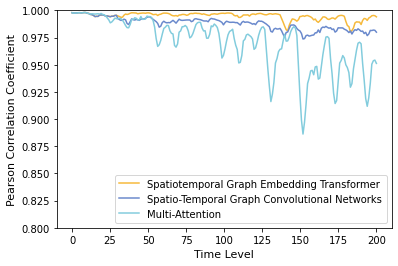

In [19]:
for i in range(number_ts):
    
   
    uvw_1=ED_out_1[i].x.reshape(1,ED_out_1[i].x.shape[0],ED_out_1[i].x.shape[1]).to('cpu')
    uvw_2=ED_out_2[i].x.reshape(1,ED_out_2[i].x.shape[0],ED_out_2[i].x.shape[1]).to('cpu')
    uvw_3=ED_out_3[i].x.reshape(1,ED_out_3[i].x.shape[0],ED_out_3[i].x.shape[1]).to('cpu')
    
    ouvw=ori[i].x.reshape(1,ori[i].x.shape[0],ori[i].x.shape[1])
    
    outputs_1 = uvw_1 if i==0 else np.vstack((outputs_1,uvw_1))
    outputs_2 = uvw_2 if i==0 else np.vstack((outputs_2,uvw_2))
    outputs_3 = uvw_3 if i==0 else np.vstack((outputs_3,uvw_3))
    inputs=ouvw if i==0 else np.vstack((inputs,ouvw))


output_1 = np.hstack((outputs_1[:,:,0],outputs_1[:,:,1]))
output_2 = np.hstack((outputs_2[:,:,0],outputs_2[:,:,1]))
output_3 = np.hstack((outputs_3[:,:,0],outputs_3[:,:,1]))
input_ = np.hstack((inputs[:,:,0],inputs[:,:,1]))
print(output_1.shape,output_2.shape,output_3.shape,input_.shape)

cc(input_, output_1, output_2,output_3)

In [20]:
from keras import backend as K
def root_mean_squared_error(true, pred):
    return K.mean(K.square(pred - true))
def rmse(ori_data, rom_data):

    rmse_value = []
    if len(ori_data) != len(rom_data):
        print('the length of these two array do not match')
    else:
        for i in range(len(rom_data)):
            value = root_mean_squared_error(ori_data[i], rom_data[i])

            ori=torch.Tensor(ori_data[i])
            
            k=((torch.norm(ori, p=1))/len(ori))
            
            #value =acc(ori, rom)
            
            #value =math.sqrt(acc(ori, rom))
            value=math.sqrt(value)/k

            if i == 0:
                rmse_value = value
            else:
                rmse_value = np.hstack((rmse_value,value))
        rmse_value = np.reshape(rmse_value,(-1,1))
    return rmse_value
def rmse_over_time(ori_data, rom_data_0, rom_data_1, rom_data_2):
    rmse_0 = rmse(ori_data, rom_data_0)
    rmse_1 = rmse(ori_data, rom_data_1)
    rmse_2 = rmse(ori_data, rom_data_2)
    
  
    # rmse_4 = rmse(ori_data, rom_data_4)
    # rmse_5 = rmse(ori_data, rom_data_5)
 
    # plt.figure(1)
    # x = np.linspace(5,8,600)

    fig, ax = plt.subplots()
    x = np.linspace(0,rmse_0.shape[0],rmse_0.shape[0])
    ax.set_prop_cycle(color = ['#f6b93b','#6a89cc','#82ccdd'], linestyle = ['-', '-', '-'])
    # x = np.linspace(0,15,2875)
    y_0 = rmse_0
    y_1 = rmse_1
    y_2 = rmse_2
    
   
    # y_4 = rmse_4[-1800:-1200,:]
    # y_5 = rmse_5[-1800:-1200,:]
    # plt.title('Correlation Coefficient')
    ax.plot(x, y_0, x, y_1, x, y_2)
    # , x, rmse_4, linewidth = 0.6)
    # plt.xlim((-0.1, 200.1))# range
    plt.ylim((-0.005, 1))
    plt.xlabel('Time Level',{'size' : 11})
    plt.ylabel('RRMSE',{'size' : 11})
    # plt.xticks(np.arange(0,200.1,25))
    # plt.yticks(np.arange(0,0.081,0.02))
    plt.legend(['Spatiotemporal Graph Embedding Transformer ','Spatio-Temporal Graph Convolutional Networks', 'Multi-Attention'], loc='upper right')   
    plt.show()
    fig.savefig('/root/data1/STGCN_result/'+'S-ST-MA_RRMSE.pdf', bbox_inches='tight')

2024-11-19 20:02:58.731616: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-11-19 20:02:58.748263: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 8254 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4090, pci bus id: 0000:9e:00.0, compute capability: 8.9


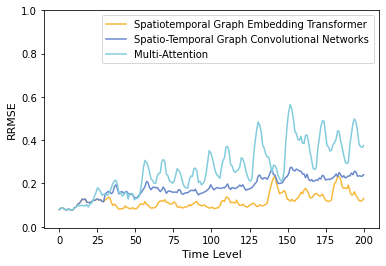

In [21]:
rmse_over_time(input_, output_1, output_2,output_3)

In [1]:
import numpy as np
import meshio
import torch
import tensorflow.compat.v1 as tf
from torch_geometric.data import Data
import torch.nn.functional as F
from torch_geometric.loader import DataLoader
import pandas as pd
import os
import time
from IPython.lib.display import isdir
import random
import matplotlib.pyplot as plt
import copy
from matplotlib import tri as mtri
from matplotlib import animation
from mpl_toolkits.axes_grid1 import make_axes_locatable

from d_pooling import *
#from mgn import *
from d_tap_processing import *
#from global_tpok_mp import *

from d_TAP_MP_Attention import *
from GTF import *
from self_attention import *

/usr/local/lib/python3.8/dist-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
per_t=1     
satart_number_ts=200
number_ts=11
batch_size = int(number_ts/per_t)
dataset_dir = '/root/data1/d_0.4_EMD'
path='/root/data1/d_slice_'     #将文件命名为yuan_0
number_trajectories=1
device='cuda'

#get_dataset(number_trajectories,satart_number_ts,number_ts,per_t,batch_size,dataset_dir,path)

file_path= dataset_dir+'/meshgraphnets_miniset'+str(per_t)+str(batch_size)+str(number_trajectories)+'traj'+str(satart_number_ts)+str(number_ts)+'ts_vis.pt'
dataset_M = torch.load(file_path)
print(len(dataset_M))   #长度为1  

perm_list=torch.load(dataset_dir+'/perm_list_150.pt')

print(device)
for i in range(len(perm_list[0])):
   
    perm_list[0][i]=perm_list[0][i].to(device)
print(perm_list[0][0].device)
pathE='/root/data1/d_0.4_EMD/Encode_state_dict.pt'

in_channels_node = 2 #2
in_channels_edge = 3 #3
hidden_channels = 26#24    #22#12
out_channels = in_channels_node

n_mlp_encode = 4
n_mlp_mp = 5#5
encoding_dim=32#32
ae_dim=[160,128,64,32]#[128,64,32,16,10][300,128,64,32]
n_mp_down = [2,2,1,1]
n_mp_up= [1,1,2,2]
pool_num =[6500,4800,3900]#[2000,1500,1200,1000][2000,1600,1400,1000]

[EDmean_vec_x,EDstd_vec_x,EDmean_vec_edge,EDstd_vec_edge] = torch.load(dataset_dir+'/EDstats_list.pt')

(EDmean_vec_x,EDstd_vec_x,EDmean_vec_edge,EDstd_vec_edge)=(EDmean_vec_x.to(device),
        EDstd_vec_x.to(device),EDmean_vec_edge.to(device),EDstd_vec_edge.to(device))

act = F.elu
param_sharing = False

1
cuda
cuda:0


In [3]:

M_encode=GNN_topk_encode(
                hidden_channels,
                in_channels_node,
                in_channels_edge,
                
                out_channels,
                encoding_dim,
                n_mlp_mp,
                n_mlp_encode,

                ae_dim,
                n_mp_down,
                n_mp_up,
                pool_num,
                
                act,
                
                name='gnn_topk')
M_encode.to(device)
M_encode.load_state_dict(torch.load(pathE), strict=False)




with torch.no_grad():
  for i in range(len(dataset_M)):
    dataset_M[i]=dataset_M[i].to(device)
    data_list,batches , xs, positions, edge_attrs, edge_indices, edge_masks= M_encode(dataset_M[i], per_t , perm_list[0],
                                                                                            batch_size,EDmean_vec_x,EDstd_vec_x,
                                                                                            EDmean_vec_edge,EDstd_vec_edge,
                                                                                            batch=None, return_mask=False)  
    torch.save(data_list,dataset_dir+'/M_encode_output_'+str(i)+str(number_trajectories)+'traj'+str(per_t)+str(batch_size)+str(satart_number_ts)+str(number_ts)+'ts_vis.pt')
    torch.save(batches,dataset_dir+'/'+str(satart_number_ts)+str(number_ts)+str(i)+str(number_trajectories)+'traj'+'batches.pt')
    torch.save(xs,dataset_dir+'/'+str(satart_number_ts)+str(number_ts)+str(i)+str(number_trajectories)+'traj'+'xs.pt')
    torch.save( positions,dataset_dir+'/'+str(satart_number_ts)+str(number_ts)+str(i)+str(number_trajectories)+'traj'+'positions.pt')
    torch.save( edge_attrs,dataset_dir+'/'+str(satart_number_ts)+str(number_ts)+str(i)+str(number_trajectories)+'traj'+'edge_attrs.pt')
    torch.save( edge_indices,dataset_dir+'/'+str(satart_number_ts)+str(number_ts)+str(i)+str(number_trajectories)+'traj'+'edge_indices.pt')
    torch.save( edge_masks,dataset_dir+'/'+str(satart_number_ts)+str(number_ts)+str(i)+str(number_trajectories)+'traj'+'edge_masks.pt')
    
    print(len(data_list))#30
    print(data_list[0],data_list[1],data_list[2],data_list[3],data_list[4],data_list[5])

11
Data(x=[3900, 26], edge_index=[2, 14586], edge_attr=[14586, 26]) Data(x=[3900, 26], edge_index=[2, 14586], edge_attr=[14586, 26]) Data(x=[3900, 26], edge_index=[2, 14586], edge_attr=[14586, 26]) Data(x=[3900, 26], edge_index=[2, 14586], edge_attr=[14586, 26]) Data(x=[3900, 26], edge_index=[2, 14586], edge_attr=[14586, 26]) Data(x=[3900, 26], edge_index=[2, 14586], edge_attr=[14586, 26])


In [4]:
per_t=1     
batch_size = int(number_ts/per_t)
data_encode=torch.load(dataset_dir+'/M_encode_output_'+str(0)+str(number_trajectories)
                                             +'traj'+str(per_t)+str(batch_size)+str(satart_number_ts)+str(number_ts)+'ts_vis.pt')
print(len(data_encode)) #10
data=copy.deepcopy(data_encode[0:10])
a=copy.deepcopy(data_encode[0])
print(a)
edge_num=a.edge_attr.shape[0]
print(edge_num)

11
Data(x=[3900, 26], edge_index=[2, 14586], edge_attr=[14586, 26])
14586


In [5]:
device='cuda'
class objectview(object):
    def __init__(self, d):
        self.__dict__ = d   
for args in [
        {'model_type': 'Multi-attention',
         
         'batchsize': 5,       #是lable上的batchsize
         'hidden_dim': 26,     #这里的hidden_dim与encode_decode中的hidden_channels相同
         'epochs': 1000,#5000
         
         'train_size':150, #45
         'test_size': 40, #10         #按照lable的来
         'device':'cuda',
         'shuffle': False,
         'save_best_model': True,
         'checkpoint_dir': '/root/data1/d_0.4_EMD/Multi-attention_best_models/',
         'postprocess_dir': '/root/data1/d_0.4_EMD/Multi-attention_loss_plots/',
         'd_k': 28,#28
         'd_v': 28,
         'input_shape': 12,   #加上时间信息，所以比n_graph_encode的最后一个多两维
         'n_heads': 6,
         'n_layers': 5,
         'ff_dim': 64,
         'seq_len': 10,        #改per_t-1,二推一
         'per_t':11,
         
        'n_graph_encode':[500,150,80,10],
        'pool_num':[6500,4800,3900]},
]:
        args = objectview(args)
torch.manual_seed(5)  #Torch
random.seed(5)        #Python
np.random.seed(5)     #NumPy
torch.cuda.manual_seed_all(5)   #GPU

In [6]:
model_name='Multi-attention_model_nl'+'_bs'+str(args.batchsize) + \
               '_hd'+str(args.hidden_dim)+'_ep'+str(args.epochs)+'_wd' + \
               '_shuff_'+str(args.shuffle)+'_dk'+str(args.d_k)+'_heads'+str(args.n_heads)
args.batchsize=1
node_model = self_transformer(args,edge_num).to(device)
node_model.load_state_dict(torch.load('/root/data1/d_0.4_EMD/Multi-attention_best_models/'+model_name+'.pt'))

EDstats_list=torch.load('/root/data1/d_0.4_EMD/EDstats_list.pt')
data_stats_list=torch.load('/root/data1/d_0.4_EMD/data_stats_list.pt')
[EDmean_vec_x,EDstd_vec_x,EDmean_vec_edge,EDstd_vec_edge] = EDstats_list
(EDmean_vec_x,EDstd_vec_x,EDmean_vec_edge,EDstd_vec_edge)=(EDmean_vec_x.to(device),
        EDstd_vec_x.to(device),EDmean_vec_edge.to(device),EDstd_vec_edge.to(device))
[mean_vec_x,std_vec_x,mean_vec_edge,std_vec_edge] = data_stats_list
(mean_vec_x,std_vec_x,mean_vec_edge,std_vec_edge)=(mean_vec_x.to(device),std_vec_x.to(device),
                                                   mean_vec_edge.to(device),std_vec_edge.to(device))

In [7]:
def predict_sequences_multiple(model, data, a, predict_num,seq_len):

        print('[Model] Predicting Sequences Multiple...')
        a=a.to(device)
        code_index=a.edge_index
        for i in range(predict_num):
          list_p = data[:] if i == 0 else data[i:]
          data_loader=DataLoader(list_p, batch_size=seq_len, shuffle=False) 
          for i,batch in enumerate(data_loader):
              batch=batch.to(device)
              code_x,code_edge_attr = Mulit_attention_pred(batch,model,mean_vec_x,std_vec_x,mean_vec_edge,std_vec_edge)
          
          new_data=Data(x=code_x, edge_index=code_index, edge_attr=code_edge_attr)
          data.append(new_data)

        return data

In [8]:
predict_num=100
seq_len=10
data=predict_sequences_multiple(node_model, data, a, predict_num,seq_len)
print(len(data))  #60

[Model] Predicting Sequences Multiple...


/usr/local/lib/python3.8/dist-packages/torch_geometric/deprecation.py:12: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


110


In [9]:
torch.save(data,'/root/data1/STGCN_result/MultiAttention_110_pred')

In [10]:
decode_model=GNN_Decode(
                hidden_channels,
                in_channels_node,
                in_channels_edge,
                
                out_channels,
                encoding_dim,
                n_mlp_mp,
                n_mlp_encode,

                ae_dim,
                n_mp_down,
                n_mp_up,
                pool_num,
                
                act,
                
                name='gnn_topk')
pathD='/root/data1/d_0.4_EMD/Decode_state_dict.pt'
decode_model.load_state_dict(torch.load(pathD), strict=False)
decode_model.to(device)

i=0
batches=torch.load(dataset_dir+'/'+str(satart_number_ts)+str(number_ts)+str(i)+str(number_trajectories)+'traj'+'batches.pt')
xs=torch.load(dataset_dir+'/'+str(satart_number_ts)+str(number_ts)+str(i)+str(number_trajectories)+'traj'+'xs.pt')
positions=torch.load( dataset_dir+'/'+str(satart_number_ts)+str(number_ts)+str(i)+str(number_trajectories)+'traj'+'positions.pt')
edge_attrs=torch.load( dataset_dir+'/'+str(satart_number_ts)+str(number_ts)+str(i)+str(number_trajectories)+'traj'+'edge_attrs.pt')
edge_indices=torch.load( dataset_dir+'/'+str(satart_number_ts)+str(number_ts)+str(i)+str(number_trajectories)+'traj'+'edge_indices.pt')
edge_masks=torch.load(dataset_dir+'/'+str(satart_number_ts)+str(number_ts)+str(i)+str(number_trajectories)+'traj'+'edge_masks.pt')




perm_list=torch.load(dataset_dir+'/perm_list_150.pt')


pred_MA_x=[]
with torch.no_grad():
        for i in range(len(data)):
              x=decode_model(data[i], batches , xs, positions, edge_attrs, edge_indices, edge_masks,perm_list[0])
              x=x*EDstd_vec_x+EDmean_vec_x
              pred_MA_x.append(x)

              
print(len(pred_MA_x))

110


In [11]:
def ROM_transform_vector(data, satart_number_ts,number_ts, originalFolder, destinationFolder, fileName):

    folder = os.path.exists(destinationFolder)

    if not folder: 
        print('start to create the destination folder')   
        os.makedirs(destinationFolder)       
        copyFiles(originalFolder,destinationFolder) 

    print('start to store data as a new variable')
    
    for i in range(number_ts):
        f_filename = destinationFolder + fileName + str(i+satart_number_ts)+ ".vtk"
        reader=vtk.vtkPolyDataReader()
        reader.SetFileName(f_filename)  # SetFileName设置要读取的vtk文件
        reader.ReadAllScalarsOn()
        reader.ReadAllVectorsOn()
        reader.ReadAllTensorsOn()
        reader.Update()

        vtkdata=reader.GetOutput()  # GetOutput获取文件的数据
        num_points=vtkdata.GetNumberOfPoints() 
        point_data =vtkdata.GetPointData()
        a=data[i]
        a=a.to('cpu')
        a=a.numpy()
    
        velocity_array = point_data.GetArray('U')
        #print(velocity_array.GetTuple(0)[0:2])
        for j in range(num_points):
            original_velocity = list(velocity_array.GetTuple(j))
            original_velocity[0:2]=tuple(a[j])
            velocity_array.SetTuple(j, original_velocity)

        writer = vtk.vtkGenericDataObjectWriter()
        writer.SetFileName(f_filename)
        writer.SetInputData(vtkdata)
        writer.Write()
       
    print('transform succeed')

In [12]:
for i in range(number_trajectories):
    satart_number_ts=200
    ts=len(pred_MA_x)
    originalFolder='/root/data1/d_slice_'+str(i)
    destinationFolder='/root/data1/STGCN_result/MA_pred_ROM_d_0.4_dataset_EDoutput_'+str(ts)+str(i)
    fileName="/slice_"
    ROM_transform_vector(pred_MA_x, satart_number_ts,ts, originalFolder, destinationFolder, fileName)

start to create the destination folder
start to store data as a new variable
transform succeed


In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from d_tap_processing import *

/usr/local/lib/python3.8/dist-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def cc(ori_data, rom_data_0, rom_data_1, rom_data_2):
    pcc_0 = pearson_value(ori_data, rom_data_0)
    pcc_1 = pearson_value(ori_data, rom_data_1)
    pcc_2 = pearson_value(ori_data, rom_data_2)
    fig, ax = plt.subplots()
    x = np.linspace(1,1+(pcc_0.shape[0]*0.005),pcc_0.shape[0])
    print(pcc_0.shape, pcc_1.shape)
    ax.set_prop_cycle(color = ['red','#6a89cc','#f6b93b'], linestyle = ['-', '-', '-'],linewidth=[2,2,2])
    y_0 = pcc_0
    y_1 = pcc_1
    y_2=pcc_2
   
   
    ax.plot(x, y_0, x, y_1, x, y_2)
     
            # plt.xlim((-0.1, 200.1))# range
    plt.ylim((0.96, 1))
    plt.xlabel('Time(s)',{'size' : 11})
    plt.ylabel('Pearson Correlation Coefficient',{'size' : 11})
            # plt.xticks(np.arange(0,200.1,25))
            # plt.yticks(np.arange(0.97,1.0001,0.01))
            # plt.legend(['D4:AE+TF', 'D8:AE+TF', 'D12:AE+TF', 'D4:PCA+TF', 'D8:PCA+TF', 'D12:PCA+TF'], loc='lower right')   
    plt.legend(['MRROM','GAG-AE+STGCN', 'GAG-AE+MHSA'], loc='lower center',ncol=3)   
    plt.axis([1,1.55,0.96, 1])
    plt.xticks([1, 1.05, 1.1,1.15,1.2,1.25,1.3,1.35,1.4,1.45,1.5,1.55])
    plt.axvline(x=1.25,ls=":")
    plt.show()
    fig.savefig('/root/data1/STGCN_result/'+'test-S-ST-MA-Pcc.pdf', bbox_inches='tight')
    return y_0,y_1,y_2

In [3]:
def get(number_trajectories,satart_number_ts,number_ts,per_t,batch_size,path):
  data_list = []

  for i in range(number_trajectories):

    if os.path.isdir(path):
      path_k=path
      print(path_k)
      vtk_num=get_vtk_num(path_k)
      print(vtk_num)
      for ts in range(satart_number_ts,vtk_num):
        
        if(ts==number_ts+satart_number_ts):
          break
        point, cells, velocity=read_vtk_file(path_k+"/slice_"+str(ts+i)+".vtk")
        
        data_list.append(Data(x=velocity))
  return data_list

In [4]:
dataset_dir = '/root/data1/d_0.4_EMD'
number_trajectories=1
satart_number_ts=200
number_ts=110
path_1='/root/data1/ROM_pred_d_0.4_dataset_EDoutput_1000'
path_2='/root/data1/STGCN_result/ST_pred_ROM_d_0.4_dataset_EDoutput_1100'
path_3='/root/data1/STGCN_result/MA_pred_ROM_d_0.4_dataset_EDoutput_1100'

ED_out_1 = get(number_trajectories,satart_number_ts,number_ts,1,1,path_1)
ED_out_2=get(number_trajectories,satart_number_ts,number_ts,1,1,path_2)
ED_out_3=get(number_trajectories,satart_number_ts,number_ts,1,1,path_3)


ori=torch.load('/root/data1/d_0.4_EMD/meshgraphnets_miniset111traj200110ts_vis.pt')
print(len(ori))   #110

/root/data1/ROM_pred_d_0.4_dataset_EDoutput_1000
601
/root/data1/STGCN_result/ST_pred_ROM_d_0.4_dataset_EDoutput_1100
601
/root/data1/STGCN_result/MA_pred_ROM_d_0.4_dataset_EDoutput_1100
601
110


In [5]:
for i in range(number_ts):
    uvw_1=ED_out_1[i].x.reshape(1,ED_out_1[i].x.shape[0],ED_out_1[i].x.shape[1]).to('cpu')
    uvw_2=ED_out_2[i].x.reshape(1,ED_out_2[i].x.shape[0],ED_out_2[i].x.shape[1]).to('cpu')
    uvw_3=ED_out_3[i].x.reshape(1,ED_out_3[i].x.shape[0],ED_out_3[i].x.shape[1]).to('cpu')
    
    ouvw=ori[i].x.reshape(1,ori[i].x.shape[0],ori[i].x.shape[1])
    
    outputs_1 = uvw_1 if i==0 else np.vstack((outputs_1,uvw_1))
    outputs_2 = uvw_2 if i==0 else np.vstack((outputs_2,uvw_2))
    outputs_3 = uvw_3 if i==0 else np.vstack((outputs_3,uvw_3))
    inputs=ouvw if i==0 else np.vstack((inputs,ouvw))


output_1 = np.hstack((outputs_1[:,:,0],outputs_1[:,:,1]))
output_2 = np.hstack((outputs_2[:,:,0],outputs_2[:,:,1]))
output_3 = np.hstack((outputs_3[:,:,0],outputs_3[:,:,1]))
input_ = np.hstack((inputs[:,:,0],inputs[:,:,1]))
print(output_1.shape,output_2.shape,output_3.shape,input_.shape)



(110, 15586) (110, 15586) (110, 15586) (110, 15586)


(110, 1) (110, 1)


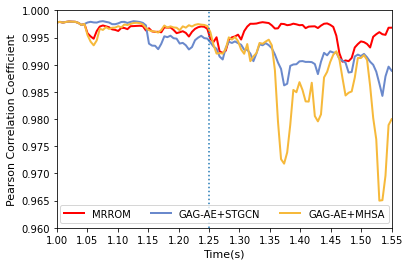

In [6]:
y_0,y_1,y_2=cc(input_, output_1, output_2,output_3)

In [7]:
print(np.mean(y_0[50:]),np.mean(y_1[50:]),np.mean(y_2[50:]))

0.9956420100959243 0.9910880191464057 0.9866882585635982


In [ ]:
acc=torch.nn.MSELoss(reduction='sum')
a=torch.Tensor([[1,2],[3,4]])
print(torch.norm(a, p=2))
print(len(a))

tensor(5.4772)
2


In [8]:

def rmse(ori_data, rom_data):

    rmse_value = []
    if len(ori_data) != len(rom_data):
        print('the length of these two array do not match')
    else:
        for i in range(len(rom_data)):
            ori=torch.Tensor(ori_data[i])
            rom=torch.Tensor(rom_data[i])
            value = torch.norm(ori-rom, p=2)

            
            
            k=(torch.norm(ori, p=2))
            
            
            value=value/k

            if i == 0:
                rmse_value = value
            else:
                rmse_value = np.hstack((rmse_value,value))
        rmse_value = np.reshape(rmse_value,(-1,1))
    return rmse_value
def rmse_over_time(ori_data, rom_data_0, rom_data_1, rom_data_2):
    rmse_0 = rmse(ori_data, rom_data_0)
    rmse_1 = rmse(ori_data, rom_data_1)
    rmse_2 = rmse(ori_data, rom_data_2)
    
  
    # rmse_4 = rmse(ori_data, rom_data_4)
    # rmse_5 = rmse(ori_data, rom_data_5)
 
    # plt.figure(1)
    # x = np.linspace(5,8,600)

    fig, ax = plt.subplots()
    x = np.linspace(1,1+rmse_0.shape[0]*0.005,rmse_0.shape[0])
    ax.set_prop_cycle(color =['red','#6a89cc','#f6b93b'], linestyle = ['-', '-', '-'],linewidth=[2,2,2])
    # x = np.linspace(0,15,2875)
    y_0 = rmse_0
    y_1 = rmse_1
    y_2 = rmse_2
    
   
    # y_4 = rmse_4[-1800:-1200,:]
    # y_5 = rmse_5[-1800:-1200,:]
    # plt.title('Correlation Coefficient')
    ax.plot(x, y_0, x, y_1, x, y_2)
    # , x, rmse_4, linewidth = 0.6)
    # plt.xlim((-0.1, 200.1))# range
    plt.ylim((0, 0.3))
    plt.xlabel('Time(s)',{'size' : 11})
    plt.ylabel('RRMSE',{'size' : 11})
    # plt.xticks(np.arange(0,200.1,25))
    # plt.yticks(np.arange(0,0.081,0.02))
     
    plt.legend(['MRROM','GAG-AE+STGCN', 'GAG-AE+MHSA'], loc='lower center',ncol=3)   
    plt.axis([1,1.55,0, 0.3])
    plt.xticks([1, 1.05, 1.1,1.15,1.2,1.25,1.3,1.35,1.4,1.45,1.5,1.55])
    plt.axvline(x=1.25,ls=":")
    plt.show()
    fig.savefig('/root/data1/STGCN_result/'+'test-S-ST-MA_RRMSE.pdf', bbox_inches='tight')
    return y_0,y_1,y_2

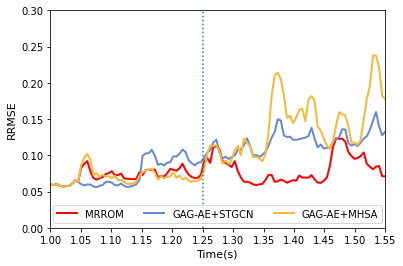

In [9]:
y_0,y_1,y_2=rmse_over_time(input_, output_1, output_2,output_3)

In [10]:
print(np.mean(y_0),np.mean(y_1),np.mean(y_2))

0.07713787 0.09833506 0.10825207


In [11]:
print(np.mean(y_0[:50]),np.mean(y_0[50:]),np.mean(y_1[:50]),np.mean(y_1[50:]),np.mean(y_2[:50]),np.mean(y_2[50:]))

0.07199818 0.08142092 0.074061766 0.11856282 0.06963588 0.14043227


速度图

In [1]:
import torch
import matplotlib.pyplot as plt
import os
from d_tap_processing import *

/usr/local/lib/python3.8/dist-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def get(number_trajectories,satart_number_ts,number_ts,per_t,batch_size,path):
  data_list = []

  for i in range(number_trajectories):

    if os.path.isdir(path):
      path_k=path
      print(path_k)
      vtk_num=get_vtk_num(path_k)
      print(vtk_num)
      for ts in range(satart_number_ts,vtk_num):
        
        if(ts==number_ts+satart_number_ts):
          break
        point, cells, velocity=read_vtk_file(path_k+"/slice_"+str(ts+i)+".vtk")
        
        data_list.append(Data(x=velocity))
  return data_list

In [3]:
dataset_dir = '/root/data1/d_0.4_EMD'
number_trajectories=1
satart_number_ts=200
number_ts=110
path_1='/root/data1/ROM_pred_d_0.4_dataset_EDoutput_1000'
path_2='/root/data1/STGCN_result/ST_pred_ROM_d_0.4_dataset_EDoutput_1100'
path_3='/root/data1/STGCN_result/MA_pred_ROM_d_0.4_dataset_EDoutput_1100'

ED_out_1 = get(number_trajectories,satart_number_ts,number_ts,1,1,path_1)
ED_out_2=get(number_trajectories,satart_number_ts,number_ts,1,1,path_2)
ED_out_3=get(number_trajectories,satart_number_ts,number_ts,1,1,path_3)


ori=torch.load('/root/data1/d_0.4_EMD/meshgraphnets_miniset111traj200110ts_vis.pt')
print(len(ori))   #110

/root/data1/ROM_pred_d_0.4_dataset_EDoutput_1000
601
/root/data1/STGCN_result/ST_pred_ROM_d_0.4_dataset_EDoutput_1100
601
/root/data1/STGCN_result/MA_pred_ROM_d_0.4_dataset_EDoutput_1100
601
110


In [10]:
def point_over_time(ori_data,rom_data_0, rom_data_1, rom_data_2 ,j,ts , fieldName):
        point = [0,ts]
        x = np.linspace(1,1+point[1]*0.005,int(point[1]-point[0]))
        y_u=[]
        y_0_u=[]
        y_1_u=[]
        y_2_u=[]
        for i in range(ts):
            y_u.append(ori_data[i].x[j,0])
            y_0_u.append(rom_data_0[i].x[j,0])
            y_1_u.append(rom_data_1[i].x[j,0])
            y_2_u.append(rom_data_2[i].x[j,0])
        print(len(y_u))
        fig, ax = plt.subplots(figsize=(12, 4))
        ax.set_prop_cycle(color = ['#2f3542','red','#6a89cc','#f6b93b'], linestyle = ['-','--', '--', '--'],linewidth=[3,2,2,2])
        
        ax.plot(x, y_u, x, y_0_u,x, y_1_u, x, y_2_u)

        plt.ylim((2, 5.5))
       

        
        plt.xlabel('Time(s)')
        plt.ylabel(fieldName)
        plt.legend(['Full Model','MRROM','GAG-AE+STGCN', 'GAG-AE+MHSA'], loc='lower center',ncol=4)   
        plt.axis([1,1.55,2, 5.5])
        plt.xticks([1, 1.05, 1.1,1.15,1.2,1.25,1.3,1.35,1.4,1.45,1.5,1.55])
        fig.savefig('/root/data1/STGCN_result/'+str(j)+'test-velocity.pdf', bbox_inches='tight')
        plt.axis([1.25,1.4,2, 5.5])
        plt.xticks([1.25,1.3,1.35,1.4])
        fig.savefig('/root/data1/STGCN_result/'+str(j)+'250-280-velocity.pdf', bbox_inches='tight')

tensor([0.0623, 0.0143])
110


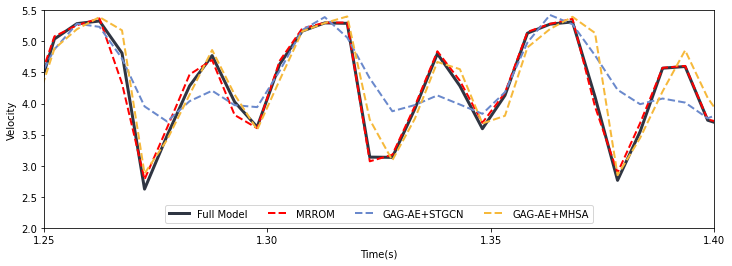

In [11]:
ts=110
j=290#7793
fieldName='Velocity'
print(ori[0].mesh_pos[j]) 
point_over_time(ori,ED_out_1,ED_out_2, ED_out_3 ,j,ts , fieldName)

误差图

In [4]:
def vtk_vector(ori,data,i,destination_vtu_path_0):
    
    reader=vtk.vtkPolyDataReader()
    reader.SetFileName(destination_vtu_path_0)  # SetFileName设置要读取的vtk文件
    reader.ReadAllScalarsOn()
    reader.ReadAllVectorsOn()
    reader.ReadAllTensorsOn()
    reader.Update()

    vtkdata=reader.GetOutput()  # GetOutput获取文件的数据
    num_points=vtkdata.GetNumberOfPoints() 
    point_data =vtkdata.GetPointData()
    
    a=ori[i].x-data[i].x
    print(a.shape)
    a=a.to('cpu')
    a=a.numpy()
    
    velocity_array = point_data.GetArray('U')
        #print(velocity_array.GetTuple(0)[0:2])
    for j in range(num_points):
            original_velocity = list(velocity_array.GetTuple(j))
            original_velocity[0:2]=tuple(a[j])
            velocity_array.SetTuple(j, original_velocity)

    writer = vtk.vtkGenericDataObjectWriter()
    writer.SetFileName(destination_vtu_path_0)
    writer.SetInputData(vtkdata)
    writer.Write()
       
    print('transform succeed')

In [7]:
import shutil
 
def copy_vtk_file(source_path, destination_path):
    shutil.copy2(source_path, destination_path)
 
# 使用方法
t=105  #0-110
satart_number_ts=200
source_vtu_path = '/root/data1/d_slice_0/slice_' + str(t+satart_number_ts)+ ".vtk"

In [8]:
destination_vtu_path_0 = '/root/data1/STGCN_result/test_GA_slice_' + str(t+satart_number_ts)+ ".vtk"
destination_vtu_path_1 = '/root/data1/STGCN_result/test_ST_slice_' + str(t+satart_number_ts)+ ".vtk"
destination_vtu_path_2 = '/root/data1/STGCN_result/test_MA_slice_' + str(t+satart_number_ts)+ ".vtk"
copy_vtk_file(source_vtu_path, destination_vtu_path_0)
copy_vtk_file(source_vtu_path, destination_vtu_path_1)
copy_vtk_file(source_vtu_path, destination_vtu_path_2)

vtk_vector(ori,ED_out_1,t,destination_vtu_path_0)
vtk_vector(ori,ED_out_2,t,destination_vtu_path_1)
vtk_vector(ori,ED_out_3,t,destination_vtu_path_2)

torch.Size([7793, 2])
transform succeed
torch.Size([7793, 2])
transform succeed
torch.Size([7793, 2])
transform succeed
